<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [4]:
data = pd.read_csv('Churn.csv', index_col='RowNumber')
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
display(data.describe())

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Датафрейм содержит 1 столбец с пропущенными значениями (Tenure). Пропущенно порядка 10% значений. Данных, по которым можно восстановить данные столбца нет, можно либо опустить строки, либо заменить значениями групповых медиан по качественным признакам. 

Данные не сбалансированы по целевому признаку. В датафрейме только 20% объектов класса 1, все остальные нули.

Строки с пустыми значениями заполним групповыми медианами, где применимо, и медианой по датафрейму. Группы выделим по Категориальным и лошическим столбцам данных:

In [6]:
df = data.groupby(['Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography']).apply(lambda x: x.fillna(x.mean()))
df = df.fillna(df.median())

C:\Users\biogr\AppData\Local\Temp\ipykernel_3896\3569628829.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = data.groupby(['Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography']).apply(lambda x: x.fillna(x.mean()))
C:\Users\biogr\AppData\Local\Temp\ipykernel_3896\3569628829.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.median())


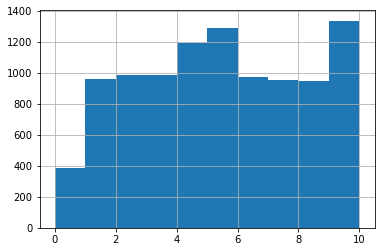

<AxesSubplot:>

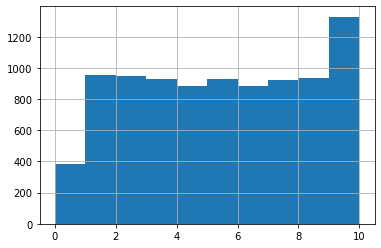

In [7]:
df['Tenure'].hist()
plt.show()
data['Tenure'].hist()

Заполнение значений проведено, распределение в столбце Tenure изменило свой характер, однако будем считать что это изменение приемлемо. 

Столбцы CustomerId, Surname не являются информативными для целей предсказания. Опустим их. 

In [8]:
df = df.drop(['CustomerId', 'Surname'], axis=1)

## Исследование задачи

Разделим датафрейм на фрейм признаков и фрейм таргетов. Для признаков проведем преобразование категориальных признаков по методу OHE, избегая дамми-ловушки. Далее проведем стандартизацию Z-оценкой.

In [9]:
df = pd.get_dummies(df, drop_first=True)

features = df.drop('Exited', axis=1)
target = df['Exited']

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])

Разделим данные на обучающую, валидационную, тестовую выборки.Данные будем стратифицировать по целевому признаку. 

In [10]:
features_train, features_valid, target_train, target_valid = (
    train_test_split(features, target, test_size=0.4, random_state=1994, stratify=target))
features_valid, features_test, target_valid, target_test = (
    train_test_split(features_valid, target_valid, test_size=0.5, random_state=1994, stratify=target_valid))

Теперь обучим разные модели (случайный лес, логистическая регрессия) без учёта дисбаланса классов и сделаем вывод, какая из моделей обладает наибольшей предсказательной силой. По каждой из моделей построим ROC-AUC кривую и определим F1 меру при дефолтном значении порога. 

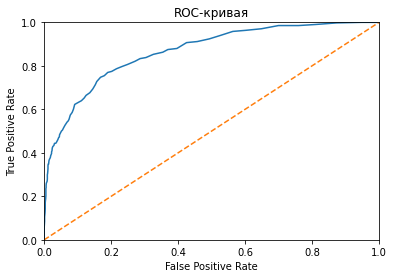

ROC-AUC score is 0.8660151246428219
F1 score is 0.5625965996908809


In [11]:
#RandomForestClassifier 
model = RandomForestClassifier(random_state=1994)
model.fit(features_train, target_train)
predicted_ones_valid = model.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, predicted_ones_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print('ROC-AUC score is', roc_auc_score(target_valid, predicted_ones_valid))
print('F1 score is', f1_score(target_valid, model.predict(features_valid)))

Лучше всего себя показывают модель случайного леса. В неоптимизированном виде она даёт неплохие AUC-ROC и F1 оценки. Логистическая регрессия показывает себя гораздо хуже. По всей видимости случайный лес способе справиться с дисбалансом данных, для логистической регрессии же необходима балансировка.  

## Борьба с дисбалансом

Перейдем к оптимизации модели и борьбе с дисбалансом. Дисбаланс модели случайного леса будем устранять методом апсэмплинга, а дисбаланс для логистической регрессии будем устранять через взвешивание классов. 

In [12]:
# определим функцию upsampling
def upsampling(features, target, repeat):
    target_ones = target[target == 1]
    features_ones = features[target == 1]
    target_zeroes = target[target == 0]
    features_zeroes = features[target == 0]
    
    features_upsampled = pd.concat([features_zeroes] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeroes] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Для балансировки данных проведем апсэмплинг с праметром 4, чтобы выровнять дисбалан классов.

In [13]:
features_upsampled, target_upsampled = upsampling(features_train, target_train, 4)
target_upsampled.mean()

0.5056900475894889

Балансировка проведена. Проведем оптимизацию модели случайного леса на изменной апсэмплингом выборке. В качестве гиперпараметров оптимизазии выберем кол-во деревьев, глубину и кол-во признаков. 

In [14]:
for n_estimators in [100, 200, 300]:
    for max_depth in [10, 20, 30]:
        for max_features in ['sqrt', None]:
            model = RandomForestClassifier(random_state=1994, n_estimators=n_estimators, max_depth=max_depth, max_features='sqrt')
            model.fit(features_upsampled, target_upsampled)
            predicted = model.predict(features_valid)
            print(f1_score(target_valid, predicted), n_estimators, max_depth, max_features)

0.6379690949227373 100 10 sqrt
0.6379690949227373 100 10 None
0.6082191780821917 100 20 sqrt
0.6082191780821917 100 20 None
0.6013605442176871 100 30 sqrt
0.6013605442176871 100 30 None
0.6407982261640798 200 10 sqrt
0.6407982261640798 200 10 None
0.6071428571428571 200 20 sqrt
0.6071428571428571 200 20 None
0.6128590971272231 200 30 sqrt
0.6128590971272231 200 30 None
0.639470782800441 300 10 sqrt
0.639470782800441 300 10 None
0.6139154160982265 300 20 sqrt
0.6139154160982265 300 20 None
0.6114130434782609 300 30 sqrt
0.6114130434782609 300 30 None


Лучшие параметры - кол-во дерьвьев 200, глубина - 10, кол-во характеристик sqrt (не принципиально). Изучим AUC-ROC модели и  определим f1-меру при пороге=0.5. 

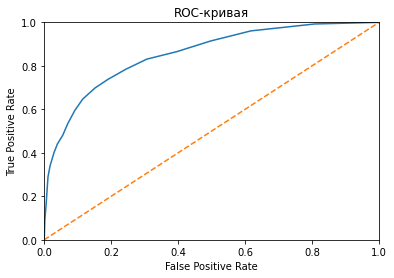

ROC-AUC score is 0.8537486759779289
0.6097867001254704


In [20]:
model_rf = RandomForestClassifier(random_state=1994, n_estimators=20, max_depth=40, max_features='sqrt')
model_rf.fit(features_upsampled, target_upsampled)
predicted = model_rf.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, predicted)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print('ROC-AUC score is', roc_auc_score(target_valid, predicted))
print(f1_score(target_valid, predicted >=0.5))

Проведена оптимизация модели случайного леса с учётом дисбаланса, определны гиперпарамеры, изучена AUC-ROC метрика, определена F1-мера, которая на валидационных данных составила 0.63. AUC-ROC модели - 0.87, что выше 0.5, можель обладает предсказательной силой, превышающей случайную модель. Устранение дисбаланса лишь незначительно улучшило F1-меру, что вероятно свидетельствует о том, что дальнейшая оптимизация нецелесообразна (соотношение ресурсоемкость / эффект становится мало). 

Перейдем логистической регрессии. Будем варьировать гиперпараметры C, max_iter, penalty. Для борьбы с дисбалансом учетм взвешивание классов при инициализации модели. 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


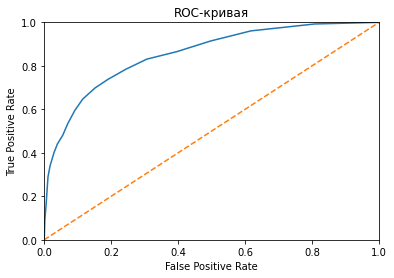

ROC-AUC score is 0.8537486759779289
0.5153153153153153 0.1 10 l1


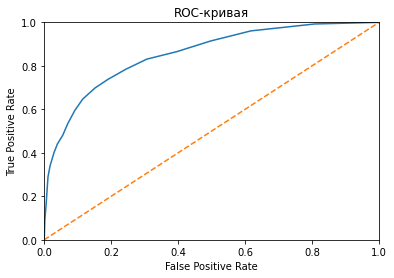

ROC-AUC score is 0.8537486759779289
0.5121293800539083 0.1 10 l2


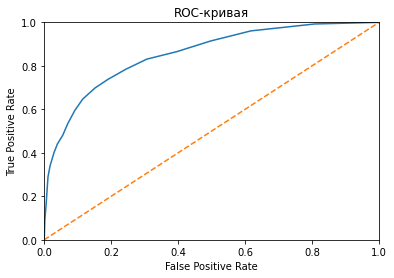

ROC-AUC score is 0.8537486759779289
0.5153153153153153 0.1 100 l1


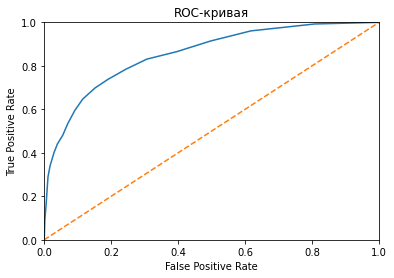

ROC-AUC score is 0.8537486759779289
0.5121293800539083 0.1 100 l2


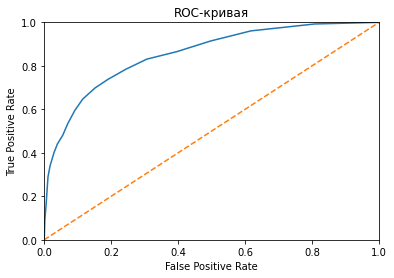

ROC-AUC score is 0.8537486759779289
0.5153153153153153 0.1 500 l1


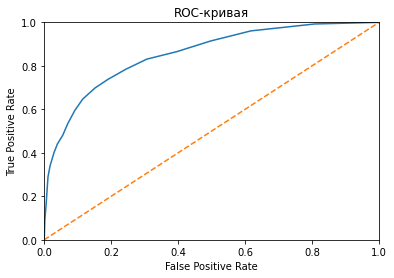

ROC-AUC score is 0.8537486759779289
0.5121293800539083 0.1 500 l2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


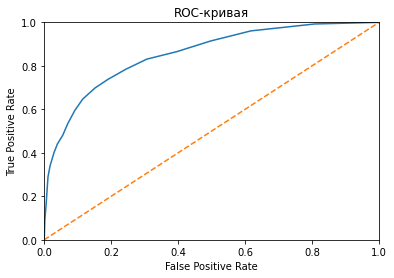

ROC-AUC score is 0.8537486759779289
0.5093833780160857 0.5 10 l1


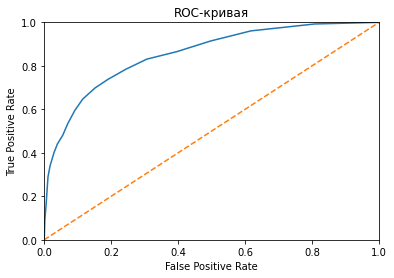

ROC-AUC score is 0.8537486759779289
0.5084444444444444 0.5 10 l2


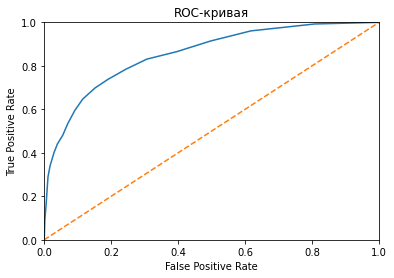

ROC-AUC score is 0.8537486759779289
0.5089285714285714 0.5 100 l1


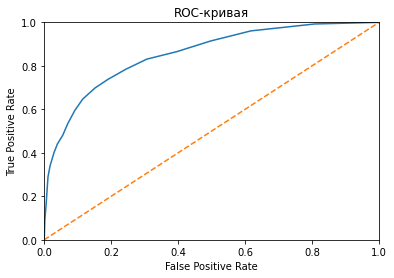

ROC-AUC score is 0.8537486759779289
0.5084444444444444 0.5 100 l2


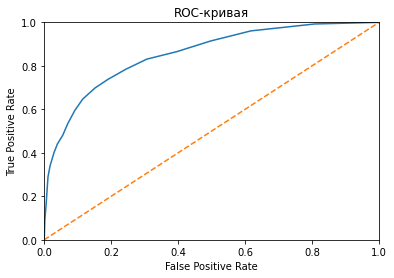

ROC-AUC score is 0.8537486759779289
0.5089285714285714 0.5 500 l1


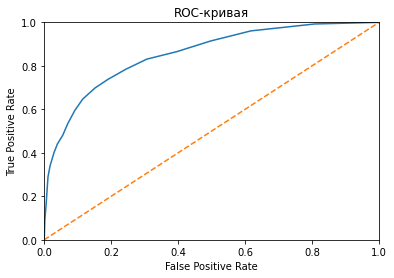

ROC-AUC score is 0.8537486759779289
0.5084444444444444 0.5 500 l2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


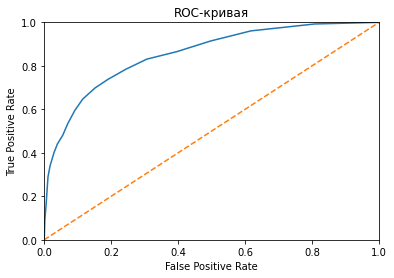

ROC-AUC score is 0.8537486759779289
0.5079928952042628 1 10 l1


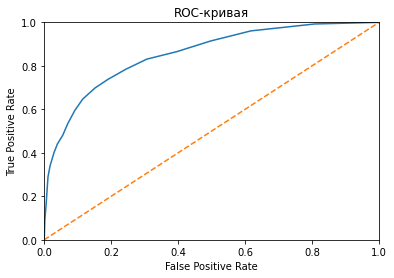

ROC-AUC score is 0.8537486759779289
0.5093167701863354 1 10 l2


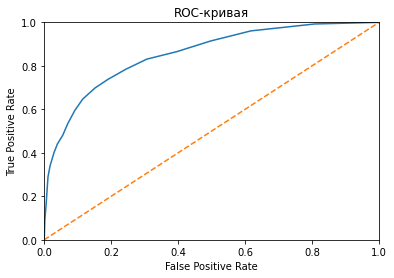

ROC-AUC score is 0.8537486759779289
0.5075421472937002 1 100 l1


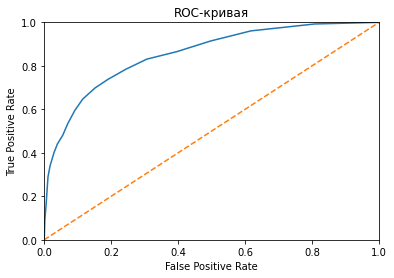

ROC-AUC score is 0.8537486759779289
0.5093167701863354 1 100 l2


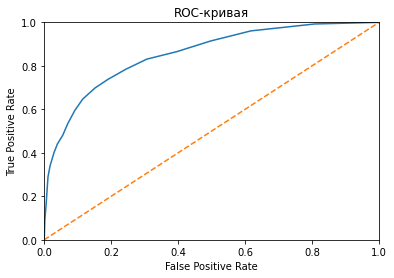

ROC-AUC score is 0.8537486759779289
0.5075421472937002 1 500 l1


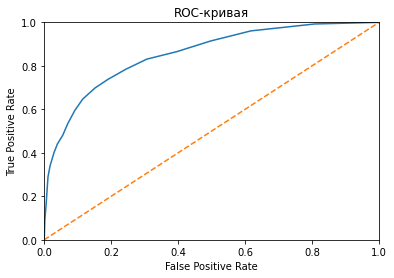

ROC-AUC score is 0.8537486759779289
0.5093167701863354 1 500 l2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


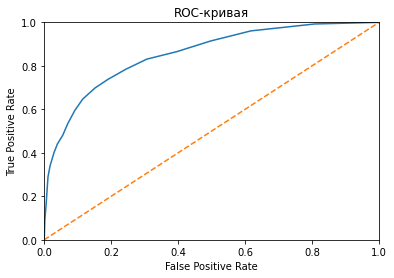

ROC-AUC score is 0.8537486759779289
0.5110913930789708 100 10 l1


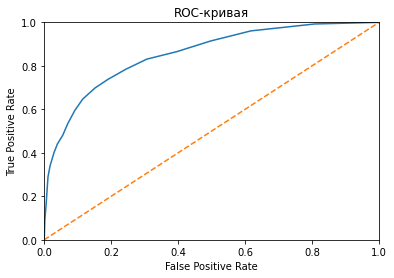

ROC-AUC score is 0.8537486759779289
0.5110913930789708 100 10 l2


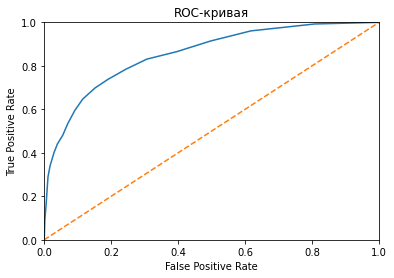

ROC-AUC score is 0.8537486759779289
0.5110913930789708 100 100 l1


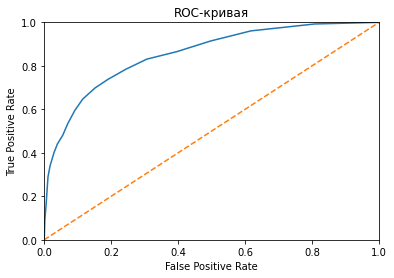

ROC-AUC score is 0.8537486759779289
0.5110913930789708 100 100 l2


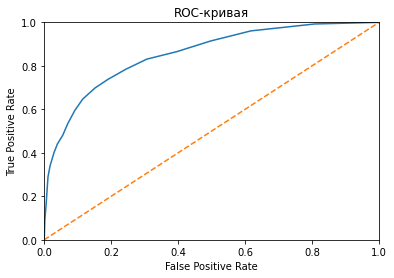

ROC-AUC score is 0.8537486759779289
0.5110913930789708 100 500 l1


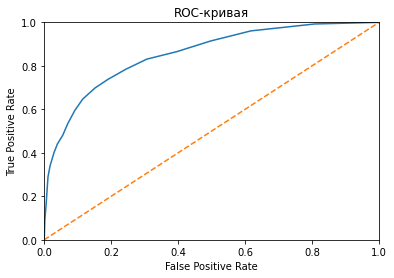

ROC-AUC score is 0.8537486759779289
0.5110913930789708 100 500 l2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


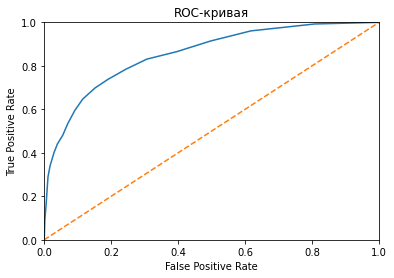

ROC-AUC score is 0.8537486759779289
0.5110913930789708 500 10 l1


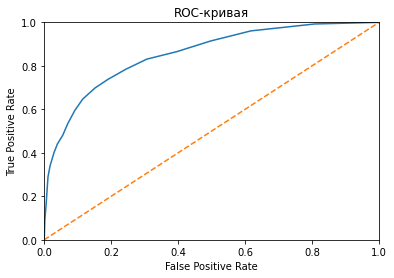

ROC-AUC score is 0.8537486759779289
0.5110913930789708 500 10 l2


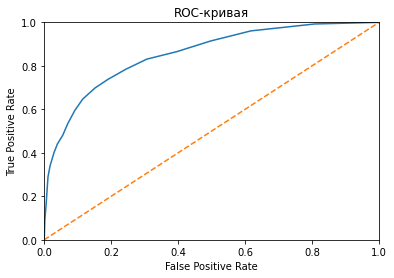

ROC-AUC score is 0.8537486759779289
0.5110913930789708 500 100 l1


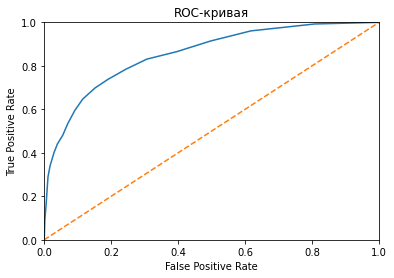

ROC-AUC score is 0.8537486759779289
0.5110913930789708 500 100 l2


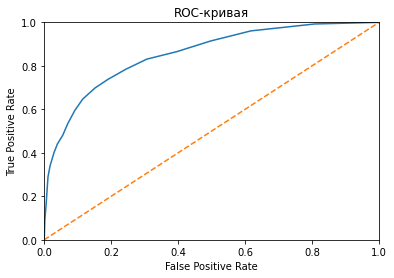

ROC-AUC score is 0.8537486759779289
0.5110913930789708 500 500 l1


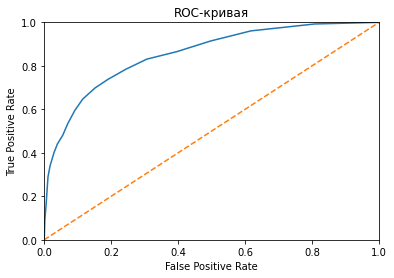

ROC-AUC score is 0.8537486759779289
0.5110913930789708 500 500 l2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


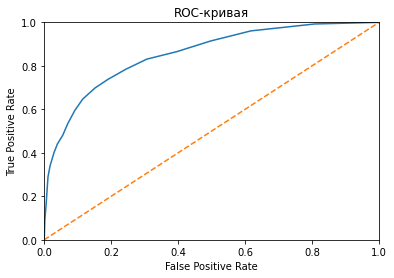

ROC-AUC score is 0.8537486759779289
0.5110913930789708 1000 10 l1


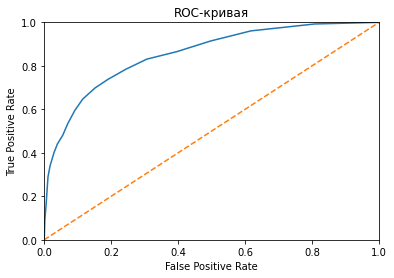

ROC-AUC score is 0.8537486759779289
0.5110913930789708 1000 10 l2


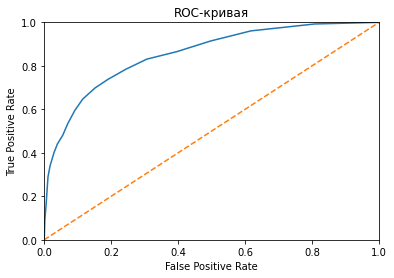

ROC-AUC score is 0.8537486759779289
0.5110913930789708 1000 100 l1


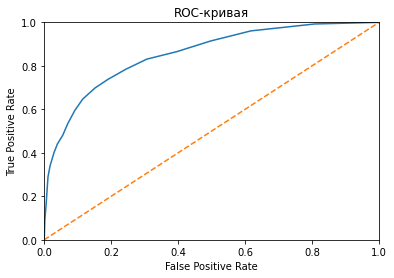

ROC-AUC score is 0.8537486759779289
0.5110913930789708 1000 100 l2


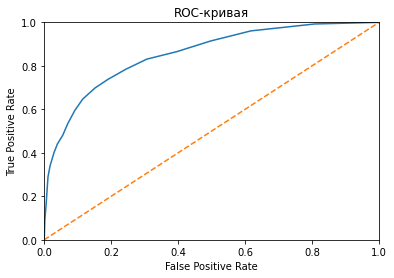

ROC-AUC score is 0.8537486759779289
0.5110913930789708 1000 500 l1


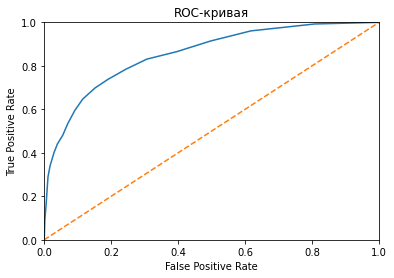

ROC-AUC score is 0.8537486759779289
0.5110913930789708 1000 500 l2


In [21]:
for C in [0.1, 0.5, 1, 100, 500, 1000]:
    for max_iter in [10, 100, 500]:
        for penalty in ['l1', 'l2']:
            model = LogisticRegression(random_state=1994, class_weight='balanced', max_iter=max_iter, solver='liblinear', C=C, penalty=penalty)
            model.fit(features_valid, target_valid)
            predicted = model.predict(features_valid)
            predicted_ones_valid = model_rf.predict_proba(features_valid)[:,1]
            fpr, tpr, thresholds = roc_curve(target_valid, predicted_ones_valid)
            plt.figure()
            plt.plot(fpr, tpr)
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.xlim([0,1])
            plt.ylim([0,1])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC-кривая')
            plt.show()
            print('ROC-AUC score is', roc_auc_score(target_valid, predicted_ones_valid))
            plt.show()
            print(f1_score(target_valid, predicted), C, max_iter, penalty)

Наибольший вклад в оптимизацию модели логистической регрессии внесла балансировка классов, остальные гиперпараметры не оказали существенного влияния на предсказательную силу модели. Логистическая регрессия показала недостаточный результат по F1 мере. На этап тестирования отправим лучшую модель случайного леса. 

## Тестирование модели

Обучим финальную модель на объединенных обучающих и валидационных данных, предварительно валидационные данные сбалансируем методом апсемплинга.

In [17]:
features_valid_us,target_valid_us = upsampling(features_valid, target_valid, repeat=4)

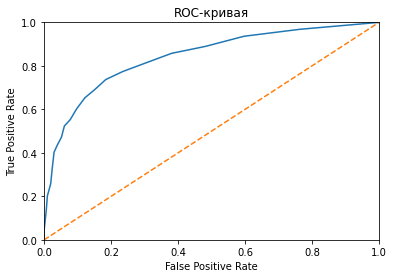

ROC-AUC score is 0.8422174100140203
0.6079404466501241


In [22]:
model_rf.fit(pd.concat([features_upsampled,features_valid_us]), pd.concat([target_upsampled,target_valid_us]))
predicted = model_rf.predict_proba(features_test)[:,1]
fpr, tpr, thresholds = roc_curve(target_test, predicted)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print('ROC-AUC score is', roc_auc_score(target_test, predicted))
print(f1_score(target_test, predicted >=0.5))

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*